## Stock Performance Tracker


## Setup


In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils, read_utils, draw_utils, process_utils, const


In [24]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")


## Read data


### Log table


In [25]:
log_df = read_utils.read_log()
# log_df.tail()


### Cashflow


In [26]:
cf_df = read_utils.read_cashflow(const.ACC_USER_DICT, const.ACC_COMBINED_NAME)
# # Drop specific users' columns
# cf_df = cf_df[const.ALL_ACC_NAME_L]
# cf_df.tail()


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


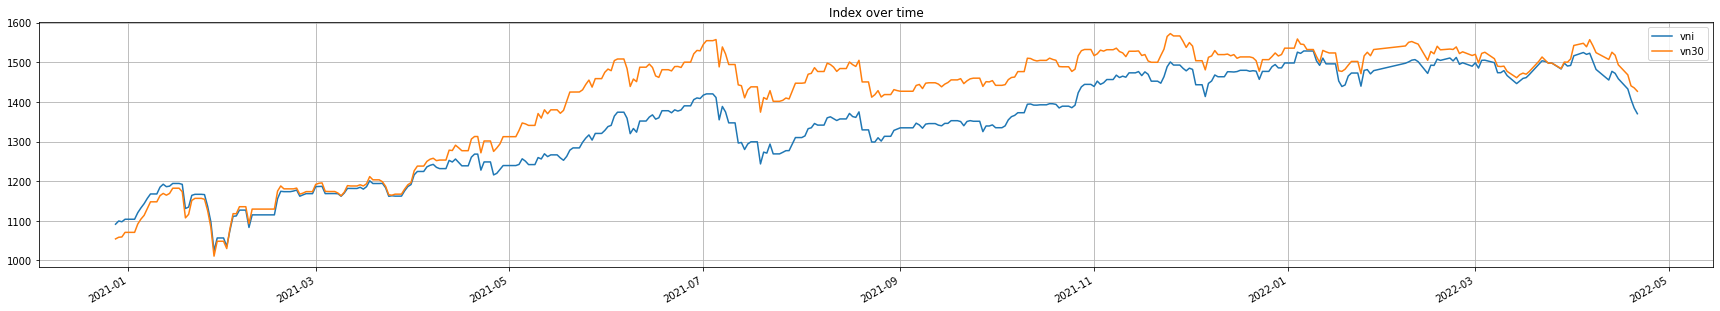

In [27]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in const.INDEX_NAME_L
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


## [Process] Processing


### Adding diff columns


In [28]:
log_df = process_utils.add_diff_column(log_df)
# log_df.tail()


### Remove unchanged dates from `log_df`


In [29]:
log_df = process_utils.remove_unchanged_rows(log_df)
# log_df.tail()


### Compensating diff with cashflow


In [30]:
log_df = process_utils.compensate_diff_with_cashflow(
    df=log_df, cashflow_df=cf_df, acc_name_l=const.ACC_NAME_L
)
# log_df.tail()


### Adding Combined columns


In [31]:
# Add acc combined cols
log_df = process_utils.add_acc_combined_cols(
    log_df,
    acc_combined_name=const.ACC_COMBINED_NAME,
    acc_name_l=const.ACC_NAME_L,
)
# Add index combined cols
log_df = process_utils.add_index_combined_cols(
    log_df,
    index_combined_name=const.INDEX_COMBINED_NAME,
    index_name_l=const.INDEX_NAME_L,
)
# log_df.tail()


### Calculating diff percent & aux diff percent


In [32]:
log_df = process_utils.add_diff_percent(
    log_df, const.ALL_ACC_NAME_L, const.ALL_INDEX_NAME_L
)
# log_df.tail()


## [Chart] NAV stack


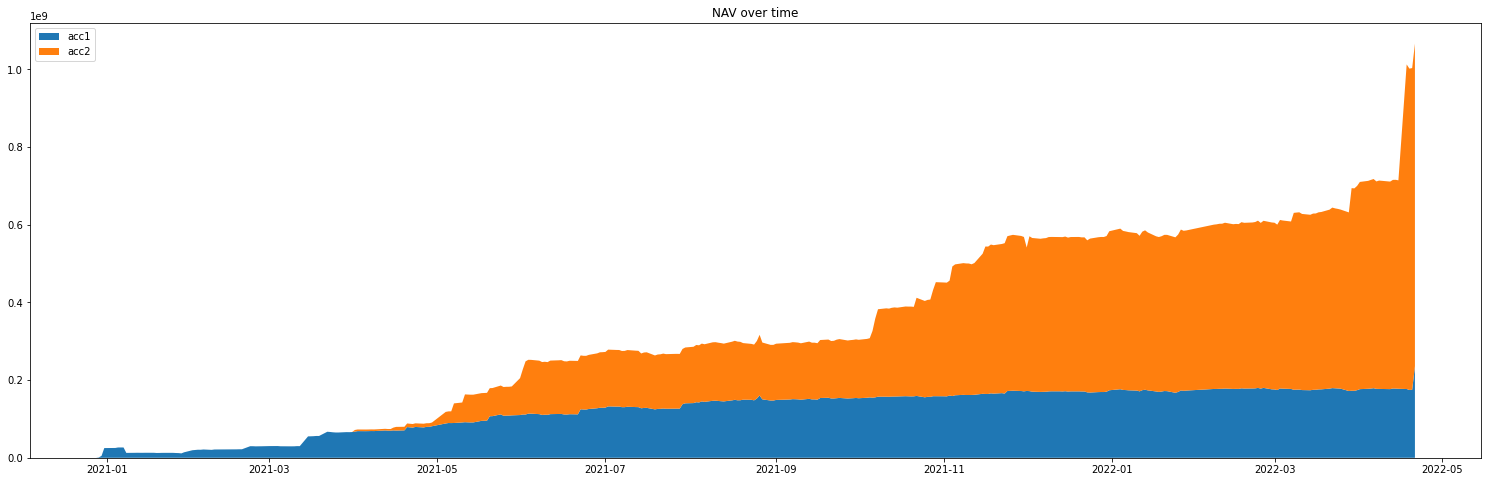

In [33]:
y_list = [log_df[acc_name] for acc_name in const.ACC_NAME_L]

draw_utils.plot_nav_stackplot(
    x=log_df.index,  # type: ignore
    y=y_list,
    labels=const.ACC_NAME_L,
)


## [Chart] NAV pie


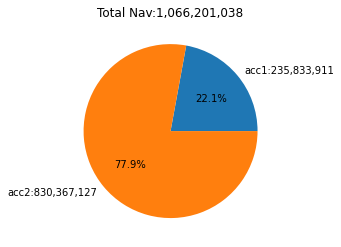

In [34]:
nav_l = [log_df[acc_name].iloc[-1] for acc_name in const.ACC_NAME_L]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(const.ACC_NAME_L, nav_l)]
draw_utils.plot_nav_pie(nav_l, label_l=label_l)


## [Chart] Profit


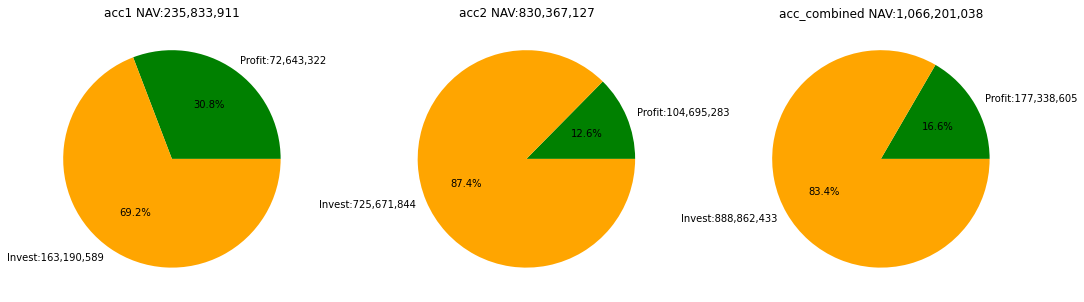

In [35]:
profit_invest_list: list[tuple[str, float, float]] = []
for name in const.ALL_ACC_NAME_L:
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest
    profit_invest_list.append((name, profit, invest))

draw_utils.plot_profit_invest_pies(profit_invest_list)


## [Chart] Diff percent


### Histogram


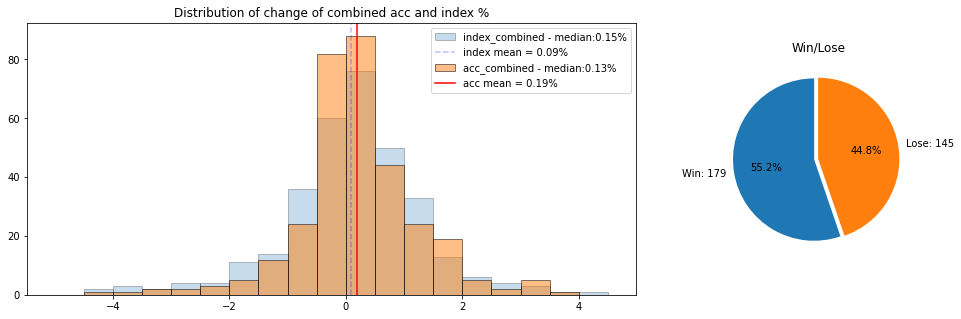

In [36]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{const.INDEX_COMBINED_NAME}_diff_p"] * 100
acc_diff_p_l = log_df[f"{const.ACC_COMBINED_NAME}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
index_combined_median = index_diff_p_l.median()
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=f"{const.INDEX_COMBINED_NAME} - median:{index_combined_median:.2f}%",
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# acc histogram
acc_combined_median = acc_diff_p_l.median()
ax1.hist(
    acc_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=f"{const.ACC_COMBINED_NAME} - median:{acc_combined_median:.2f}%",
)
acc_diff_p_mean = acc_diff_p_l.mean()  # type: ignore
ax1.axvline(
    acc_diff_p_mean,
    color="red",
    label="acc mean = %.2f%%" % acc_diff_p_mean,
)


ax1.set_title("Distribution of change of combined acc and index %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (acc_diff_p_l > index_diff_p_l).sum()
lose_num = (acc_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


## [Chart] Daily


In [37]:
# Filter 10 latest days
recent_daily_df = process_utils.filter_latest_x_rows(log_df, row_num=10)


### Latest growth


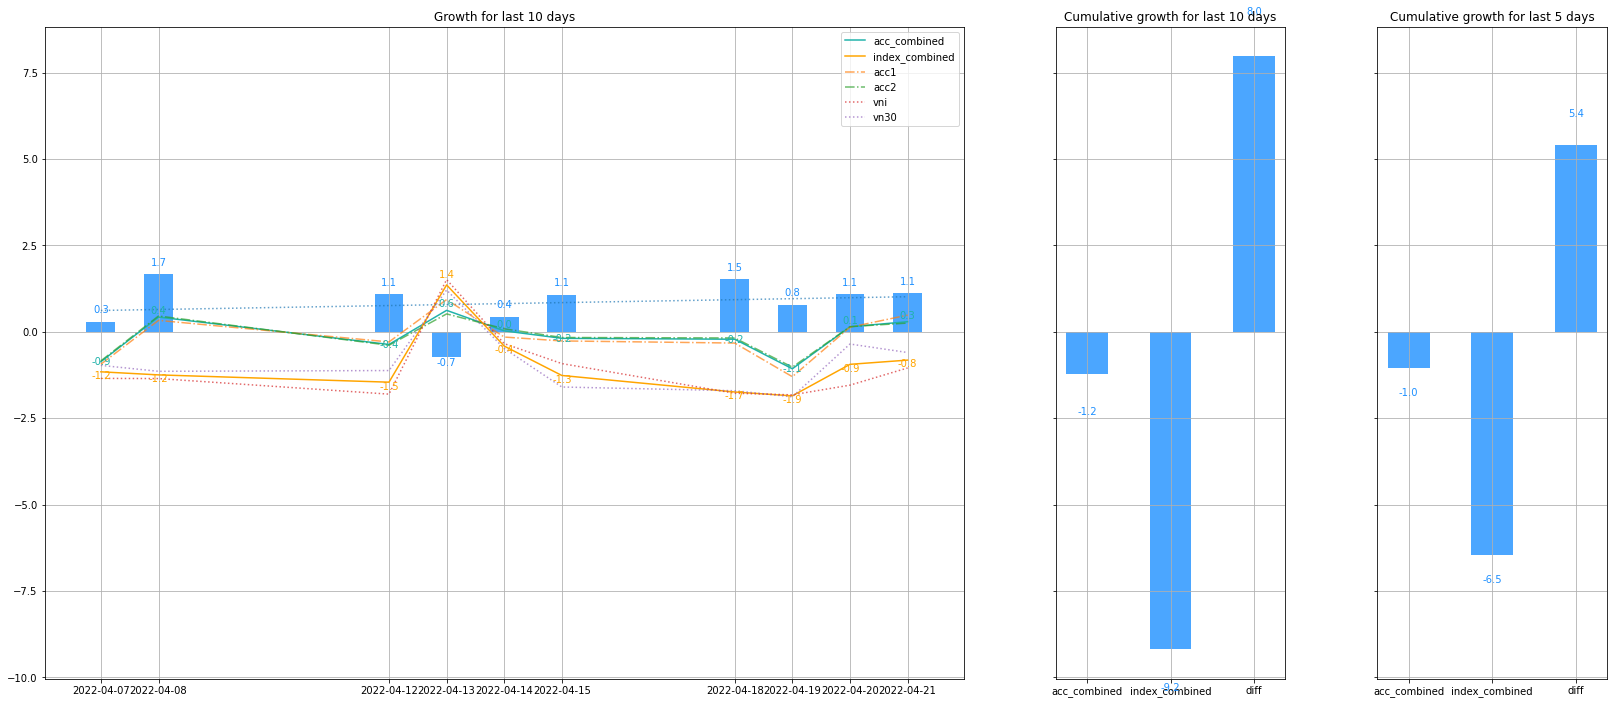

In [38]:
draw_utils.plot_recent_growth(
    recent_daily_df,
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)


In [39]:
# recent_daily_df  # type: ignore


### XIRR


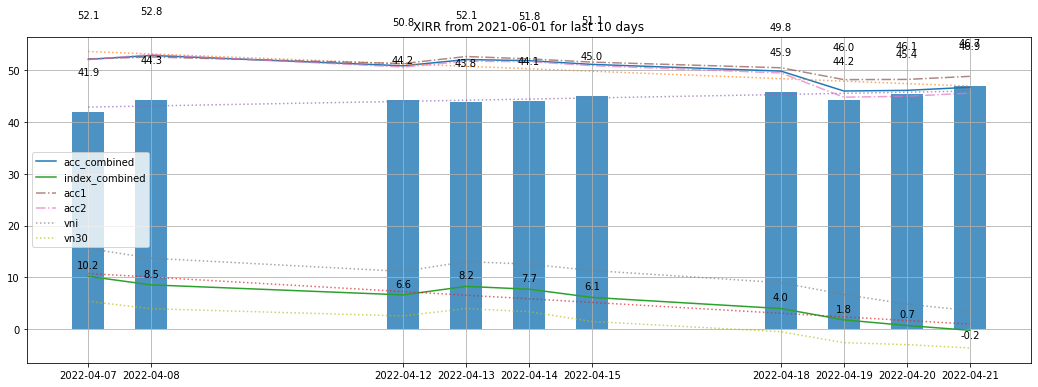

In [40]:
draw_utils.plot_recent_xirr(
    log_df=log_df,
    cf_df=cf_df,
    recent_dates_index=recent_daily_df.index,
    anchor_date='2021-06-01',
    main_acc_name=const.ACC_COMBINED_NAME,
    main_index_name=const.INDEX_COMBINED_NAME,
    secondary_acc_name_l=const.ACC_NAME_L,
    secondary_index_name_l=const.INDEX_NAME_L,
)

In [41]:
# xirr_df  # type: ignore


### Income


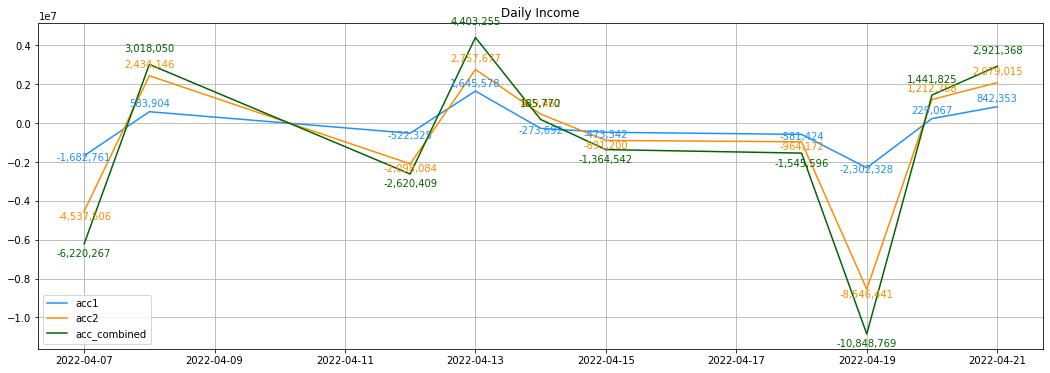

In [43]:
draw_utils.plot_recent_income(
    recent_daily_df=recent_daily_df,
    name_l=const.ALL_ACC_NAME_L,
    color_l=const.COLOR_LIST[: len(const.ALL_ACC_NAME_L)],
)


In [44]:
# recent_daily_df  # type: ignore


### Growth time series


In [45]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df: pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L:
        # calculate growth using cumulative product since anchor date

        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)

    for name in const.ALL_ACC_NAME_L:
        df[f"{name}_xirr"] = (
            filtered_log_df.index.to_series().apply(
                lambda date_idx: utils.calc_cashflow_xirr(
                    cf_df,
                    log_df,
                    anchor_date,
                    date_idx,
                    name,
                    const.ALL_ACC_NAME_L,
                )
            )
            * 100
        )
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0

    for name in const.ALL_INDEX_NAME_L:
        df[f"{name}_xirr"] = (
            filtered_log_df.index.to_series().apply(
                lambda date_idx: utils.calc_index_xirr(
                    log_df,
                    anchor_date,
                    date_idx,
                    name,
                )
            )
            * 100
        )
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0

    return df


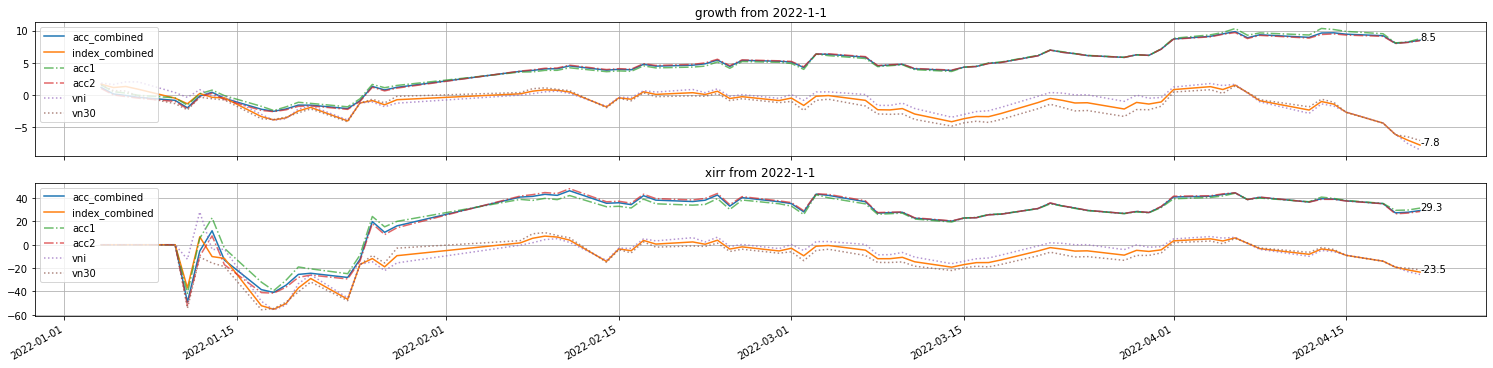

In [46]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2022-1-1"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, growth_xirr_df: pd.DataFrame, type: str):
    # Normalize growth from 0
    if type == "growth":
        growth_xirr_df = growth_xirr_df.applymap(lambda e: e - 100)

    for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            fmt="-",
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in const.ACC_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt="-.",
            alpha=0.7,
            label=single_name,
        )

    for single_name in const.INDEX_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt=":",
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()


_plot_overall_growth_xirr(ax1, growth_xirr_df, "growth")
_plot_overall_growth_xirr(ax2, growth_xirr_df, "xirr")

plt.show()


In [47]:
# growth_xirr_df  # type: ignore


## [Process] Add period info


In [48]:
log_df = process_utils.add_period_cols(log_df)
# log_df.tail()


## [Chart] Weekly


In [49]:
weekly_df = process_utils.get_period_df(
    period_symbol="W",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Not enough space to plot every week
weekly_df = process_utils.filter_latest_x_rows(df=weekly_df, row_num=20)  # type: ignore


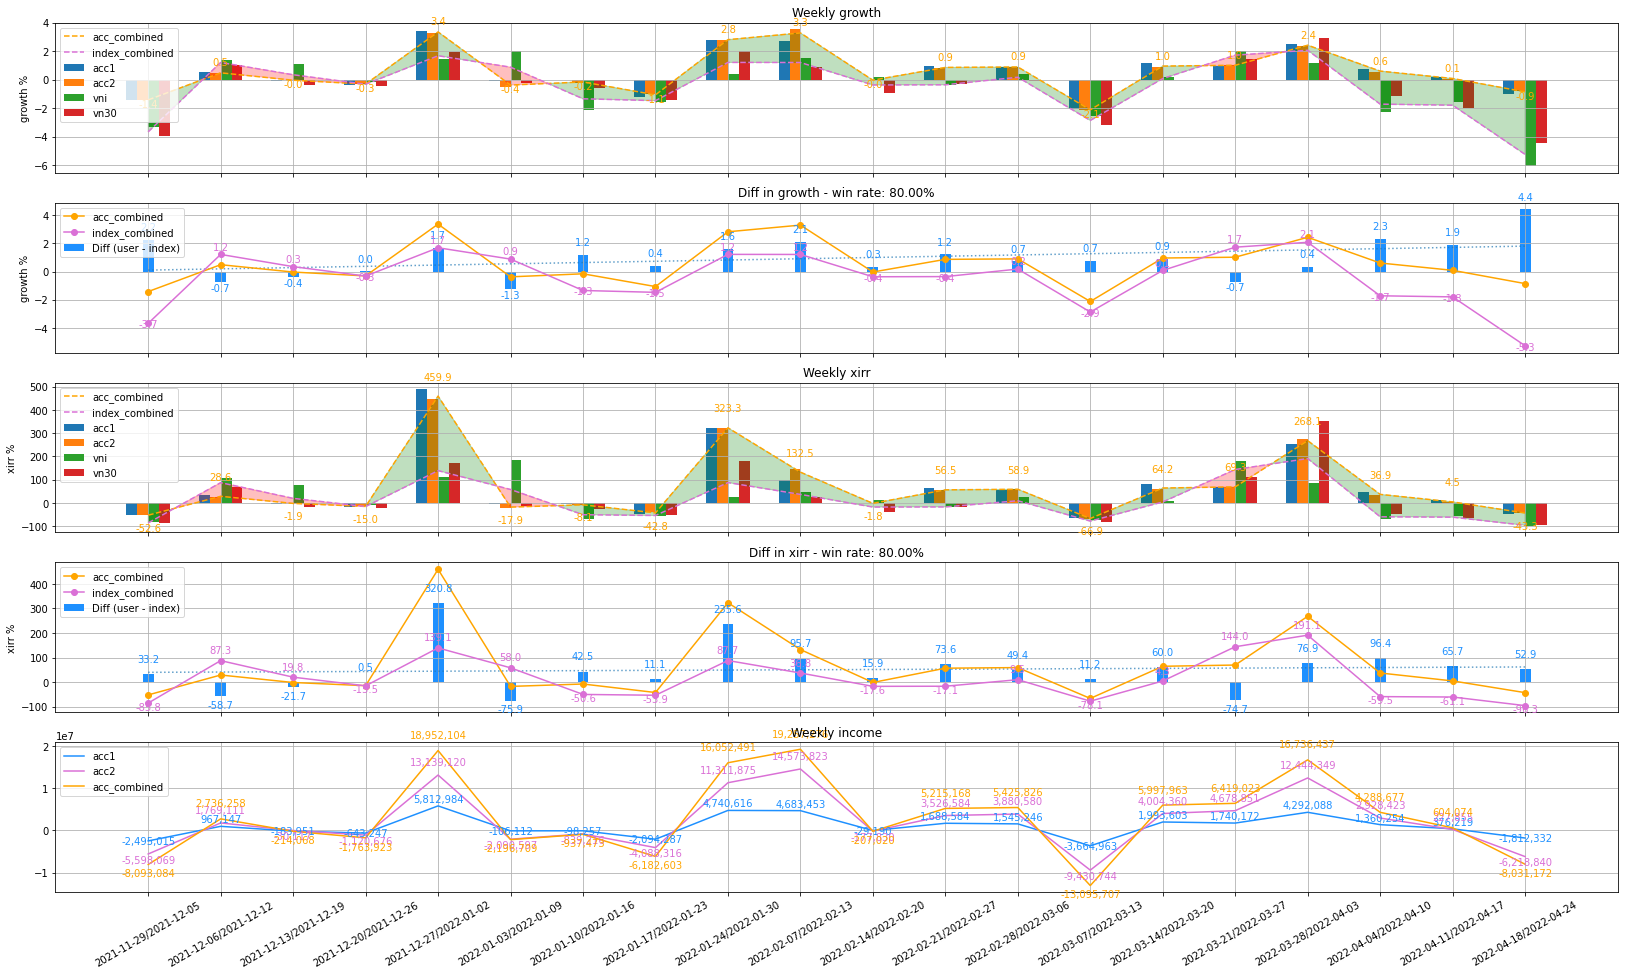

In [50]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=weekly_df,
    period_name="Weekly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [51]:
# weekly_df.tail()


## [Chart] Monthly


In [52]:
monthly_df = process_utils.get_period_df(
    period_symbol="M",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)


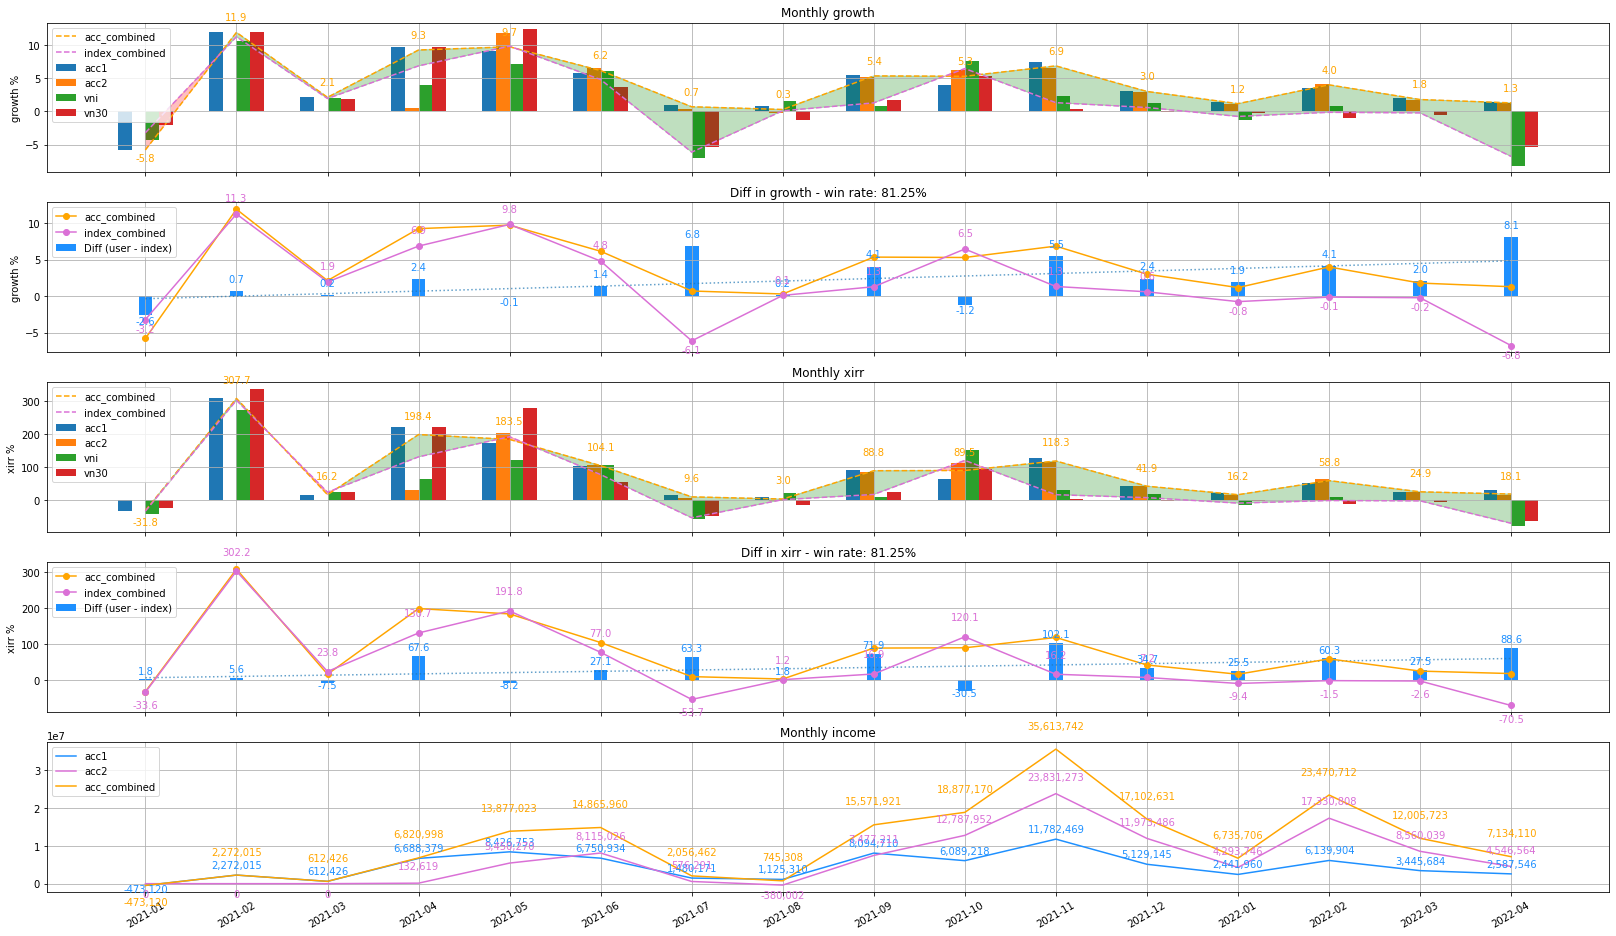

In [53]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=monthly_df,
    period_name="Monthly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [54]:
# monthly_df # type: ignore


## Quaterly


In [55]:
quaterly_df = process_utils.get_period_df(
    period_symbol="Q",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020Q4
quaterly_df.drop(["2020Q4"], inplace=True)


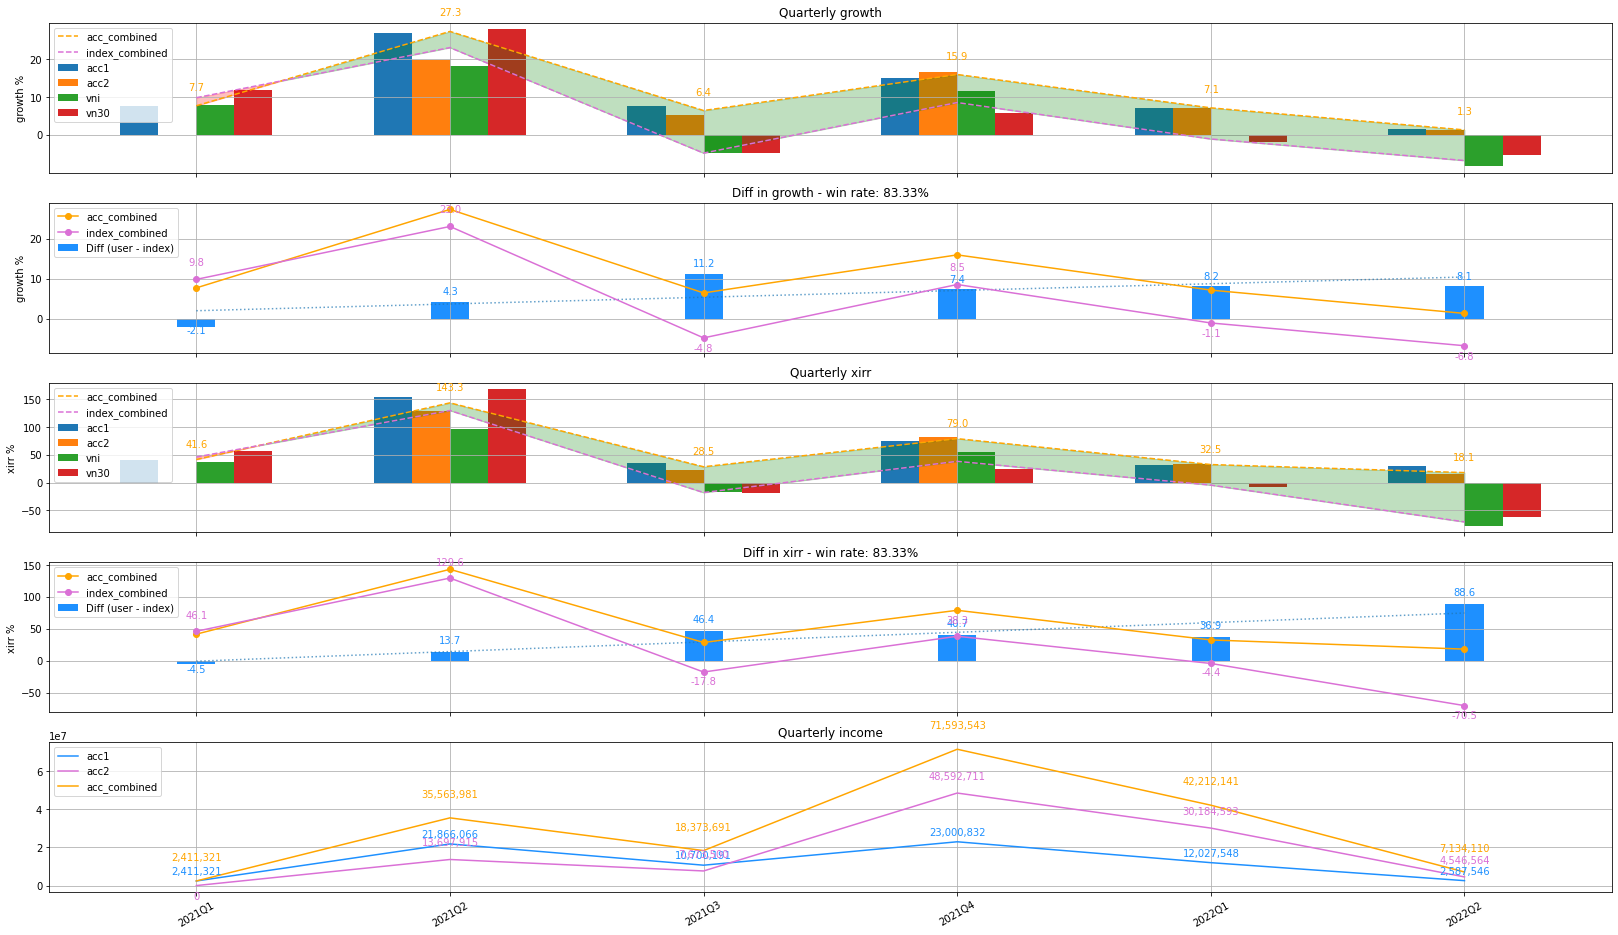

In [56]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=quaterly_df,
    period_name="Quarterly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [57]:
# quaterly_df  # type: ignore


## Yearly


In [58]:
yearly_df = process_utils.get_period_df(
    period_symbol="Y",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020
yearly_df.drop(["2020"], inplace=True)


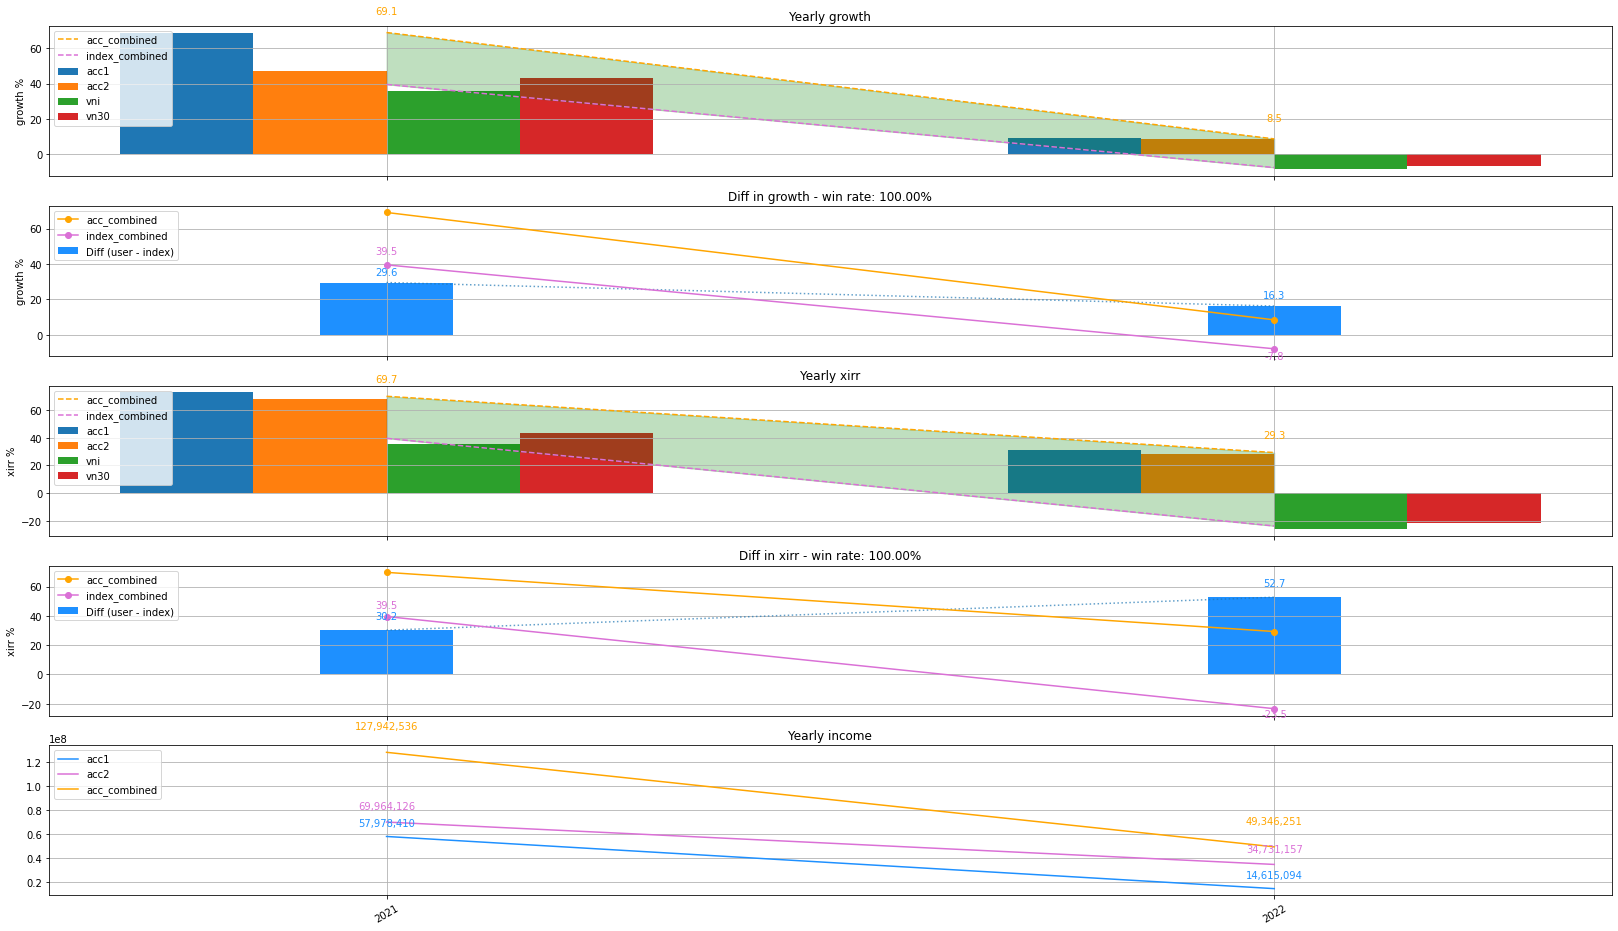

In [59]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=yearly_df,
    period_name="Yearly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [60]:
# yearly_df # noqa


## User Analysis


### Acc1

In [61]:
acc_name_1 = const.ACC1_NAME
user_name_l_1 = const.ACC_USER_DICT[acc_name_1]
compare_index_1 = const.VNI_NAME

user_df_1 = process_utils.get_user_df(
    log_df,
    cf_df,
    acc_name=acc_name_1,
    user_name_l=user_name_l_1,
    index_name=compare_index_1,
)
user_df_1.tail(10)


/Users/kaestrl/projects/python/stock_tracker/process_utils.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_cf_df[f"{acc_name}_cf"] = acc_cf_df.sum(axis=1)


,vni,vni_diff,acc1,acc1_diff,ta_cf,tn_cf,acc1_cf,day_start,ta_day_start,ta_share,ta_diff,ta,tn_day_start,tn_share,tn_diff,tn
date,,,,,,,,,,,,,,,,
2022-04-07,1502.35,-20.55,177532782,-1682761.0,0.0,0.0,0.0,179215543.0,179215543.0,1.000000,-1.682761e+06,1.775328e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-08,1482.00,-20.35,177320024,583904.0,796662.0,0.0,796662.0,176736120.0,176736120.0,1.000000,5.839040e+05,1.773200e+08,0.0,0.000000,0.000000,0.000000e+00
2022-04-12,1455.25,-26.75,176797699,-522325.0,0.0,0.0,0.0,177320024.0,177320024.0,1.000000,-5.223250e+05,1.767977e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-13,1477.20,21.95,178443277,1645578.0,0.0,0.0,0.0,176797699.0,176797699.0,1.000000,1.645578e+06,1.784433e+08,0.0,0.000000,0.000000,0.000000e+00
2022-04-14,1472.12,-5.08,178169585,-273692.0,0.0,0.0,0.0,178443277.0,178443277.0,1.000000,-2.736920e+05,1.781696e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-15,1458.56,-13.56,177696243,-473342.0,0.0,0.0,0.0,178169585.0,178169585.0,1.000000,-4.733420e+05,1.776962e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-18,1432.60,-25.96,177064819,-581424.0,50000.0,0.0,50000.0,177646243.0,177646243.0,1.000000,-5.814240e+05,1.770648e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-19,1406.45,-26.15,174762491,-2302328.0,0.0,0.0,0.0,177064819.0,177064819.0,1.000000,-2.302328e+06,1.747625e+08,0.0,0.000000,-0.000000,0.000000e+00
2022-04-20,1384.72,-21.73,174991558,229067.0,0.0,0.0,0.0,174762491.0,174762491.0,1.000000,2.290670e+05,1.749916e+08,0.0,0.000000,0.000000,0.000000e+00


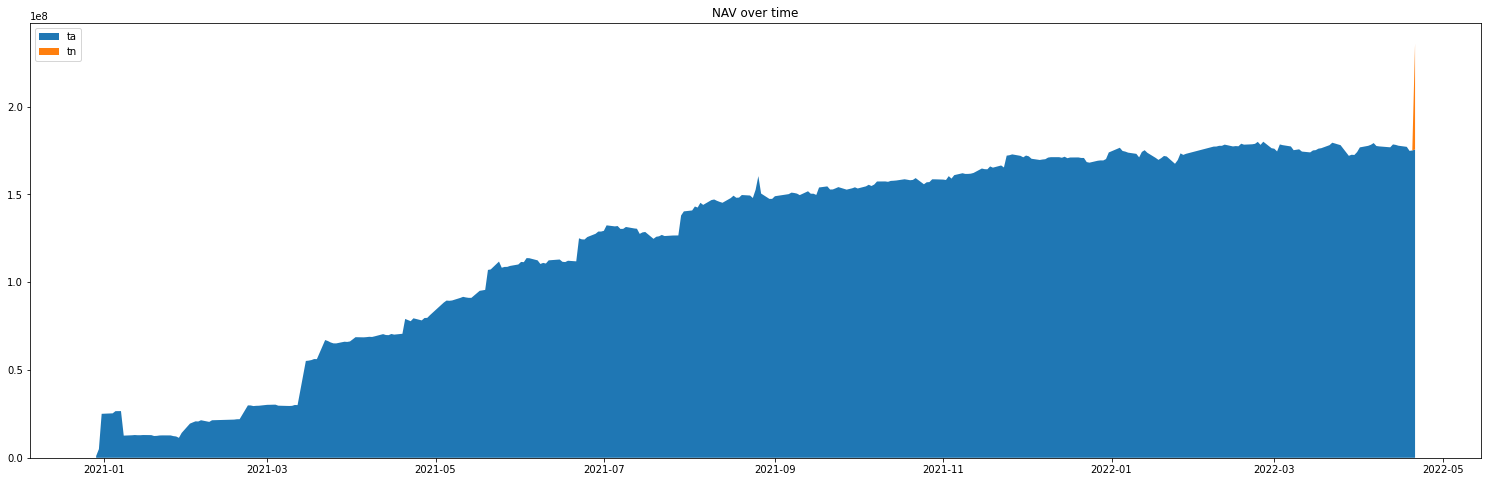

In [62]:
y_list_1 = [user_df_1[user_name] for user_name in user_name_l_1]

draw_utils.plot_nav_stackplot(
    x=user_df_1.index,  # type: ignore
    y=y_list_1,
    labels=user_name_l_1,
)

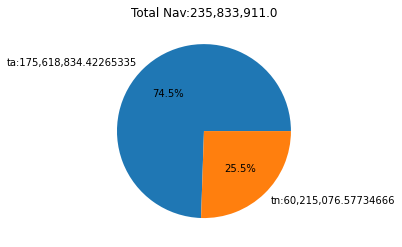

In [63]:
nav_l_1 = [user_df_1[user_name].iloc[-1] for user_name in user_name_l_1]  # type: ignore
label_l_1 = [f"{user_name}:{nav:,}" for user_name, nav in zip(user_name_l_1, nav_l_1)]
draw_utils.plot_nav_pie(nav_l_1, label_l=label_l_1)

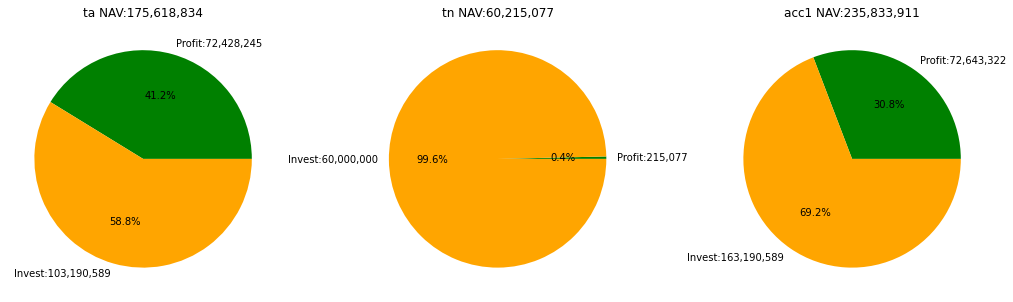

In [64]:
profit_invest_list_1: list[tuple[str, float, float]] = []
for name in user_name_l_1 + [acc_name_1]:
    nav = user_df_1[name].iloc[-1]
    invest = -user_df_1[f"{name}_cf"].sum()
    profit = nav - invest
    profit_invest_list_1.append((name, profit, invest))
draw_utils.plot_profit_invest_pies(profit_invest_list_1)


In [65]:
user_df_1 = process_utils.add_diff_percent(
    user_df_1,
    all_acc_name_l=[acc_name_1],
    index_name_combined_l=[compare_index_1],
)

In [66]:
# Filter 10 latest days
recent_user_df_1 = process_utils.filter_latest_x_rows(user_df_1, row_num=10)

In [67]:
recent_user_df_1

,vni,vni_diff,acc1,acc1_diff,ta_cf,tn_cf,acc1_cf,day_start,ta_day_start,ta_share,ta_diff,ta,tn_day_start,tn_share,tn_diff,tn,acc1_diff_p,acc1_aux_diff_p,vni_diff_p,vni_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,
2022-04-07,1502.35,-20.55,177532782,-1682761.0,0.0,0.0,0.0,179215543.0,179215543.0,1.000000,-1.682761e+06,1.775328e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.009390,0.990610,-0.013494,0.986506
2022-04-08,1482.00,-20.35,177320024,583904.0,796662.0,0.0,796662.0,176736120.0,176736120.0,1.000000,5.839040e+05,1.773200e+08,0.0,0.000000,0.000000,0.000000e+00,0.003289,1.003289,-0.013545,0.986455
2022-04-12,1455.25,-26.75,176797699,-522325.0,0.0,0.0,0.0,177320024.0,177320024.0,1.000000,-5.223250e+05,1.767977e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.002946,0.997054,-0.018050,0.981950
2022-04-13,1477.20,21.95,178443277,1645578.0,0.0,0.0,0.0,176797699.0,176797699.0,1.000000,1.645578e+06,1.784433e+08,0.0,0.000000,0.000000,0.000000e+00,0.009308,1.009308,0.015083,1.015083
2022-04-14,1472.12,-5.08,178169585,-273692.0,0.0,0.0,0.0,178443277.0,178443277.0,1.000000,-2.736920e+05,1.781696e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.001534,0.998466,-0.003439,0.996561
2022-04-15,1458.56,-13.56,177696243,-473342.0,0.0,0.0,0.0,178169585.0,178169585.0,1.000000,-4.733420e+05,1.776962e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.002657,0.997343,-0.009211,0.990789
2022-04-18,1432.60,-25.96,177064819,-581424.0,50000.0,0.0,50000.0,177646243.0,177646243.0,1.000000,-5.814240e+05,1.770648e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.003272,0.996728,-0.017798,0.982202
2022-04-19,1406.45,-26.15,174762491,-2302328.0,0.0,0.0,0.0,177064819.0,177064819.0,1.000000,-2.302328e+06,1.747625e+08,0.0,0.000000,-0.000000,0.000000e+00,-0.013003,0.986997,-0.018254,0.981746
2022-04-20,1384.72,-21.73,174991558,229067.0,0.0,0.0,0.0,174762491.0,174762491.0,1.000000,2.290670e+05,1.749916e+08,0.0,0.000000,0.000000,0.000000e+00,0.001311,1.001311,-0.015450,0.984550


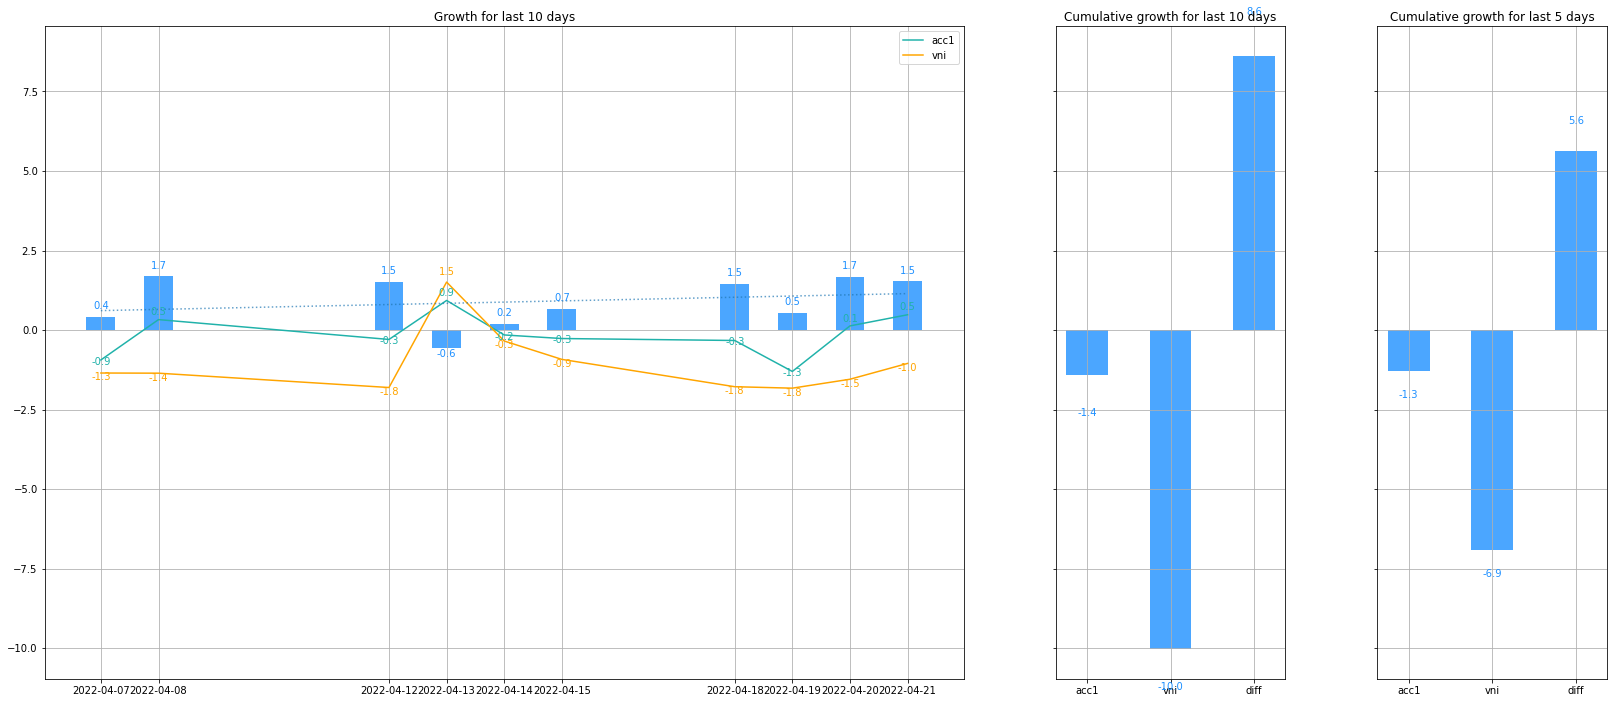

In [68]:
draw_utils.plot_recent_growth(
    recent_user_df_1,
    main_acc_name=acc_name_1,
    main_index_name=compare_index_1,
    secondary_acc_name_l=[],
    secondary_index_name_l=[],
)

### Acc2

In [69]:
acc_name_2 = const.ACC2_NAME
user_name_l_2 = const.ACC_USER_DICT[acc_name_2]
compare_index_2 = const.VNI_NAME


user_df_2 = process_utils.get_user_df(
    log_df,
    cf_df,
    acc_name=acc_name_2,
    user_name_l=user_name_l_2,
    index_name=compare_index_2,
)
user_df_2.tail(10)


/Users/kaestrl/projects/python/stock_tracker/process_utils.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_cf_df[f"{acc_name}_cf"] = acc_cf_df.sum(axis=1)


,vni,vni_diff,acc2,acc2_diff,tl_cf,la_cf,acc2_cf,day_start,tl_day_start,tl_share,tl_diff,tl,la_day_start,la_share,la_diff,la
date,,,,,,,,,,,,,,,,
2022-04-07,1502.35,-20.55,533923966,-4537506.0,0.0,0.0,0.0,538461472.0,5.384615e+08,1.0000,-4.537506e+06,5.339240e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-08,1482.00,-20.35,536358112,2434146.0,0.0,0.0,0.0,533923966.0,5.339240e+08,1.0000,2.434146e+06,5.363581e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-12,1455.25,-26.75,534260028,-2098084.0,0.0,0.0,0.0,536358112.0,5.363581e+08,1.0000,-2.098084e+06,5.342600e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-13,1477.20,21.95,537017705,2757677.0,0.0,0.0,0.0,534260028.0,5.342600e+08,1.0000,2.757677e+06,5.370177e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-14,1472.12,-5.08,537477167,459462.0,0.0,0.0,0.0,537017705.0,5.370177e+08,1.0000,4.594620e+05,5.374772e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-15,1458.56,-13.56,536585967,-891200.0,0.0,0.0,0.0,537477167.0,5.374772e+08,1.0000,-8.912000e+05,5.365860e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-18,1432.60,-25.96,835621795,-964172.0,0.0,-300000000.0,-300000000.0,836585967.0,5.365860e+08,0.6414,-6.184196e+05,5.359675e+08,3.000000e+08,0.3586,-3.457524e+05,2.996542e+08
2022-04-19,1406.45,-26.15,827075354,-8546441.0,0.0,0.0,0.0,835621795.0,5.359675e+08,0.6414,-5.481684e+06,5.304859e+08,2.996542e+08,0.3586,-3.064757e+06,2.965895e+08
2022-04-20,1384.72,-21.73,828288112,1212758.0,0.0,0.0,0.0,827075354.0,5.304859e+08,0.6414,7.778626e+05,5.312637e+08,2.965895e+08,0.3586,4.348954e+05,2.970244e+08


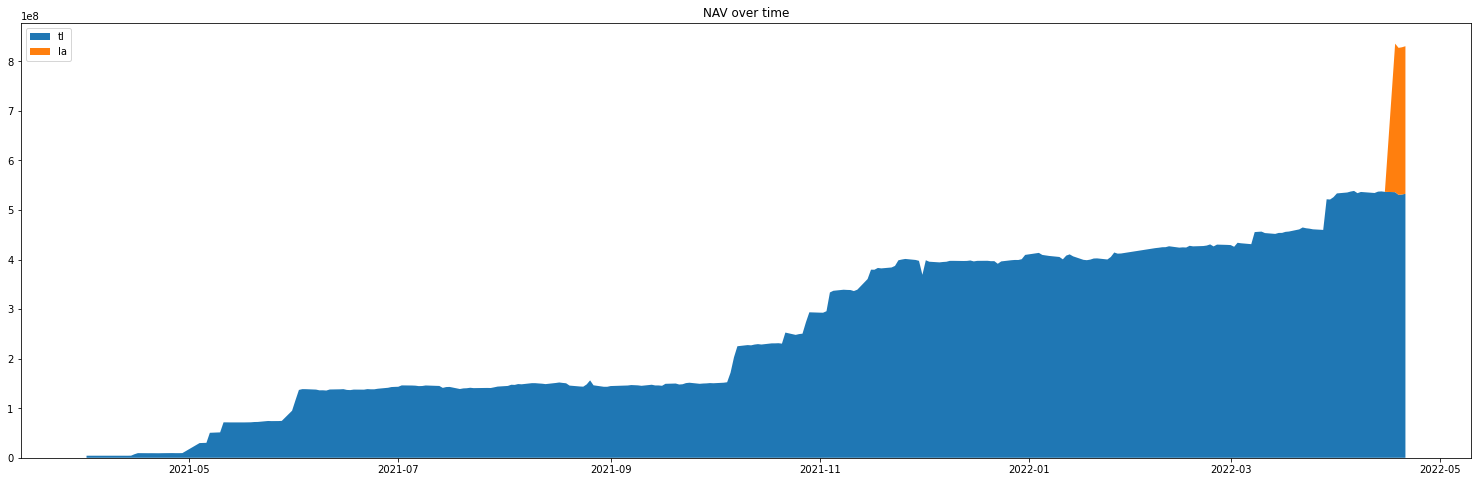

In [70]:
y_list_2 = [user_df_2[user_name] for user_name in user_name_l_2]

draw_utils.plot_nav_stackplot(
    x=user_df_2.index,  # type: ignore
    y=y_list_2,
    labels=user_name_l_2,
)


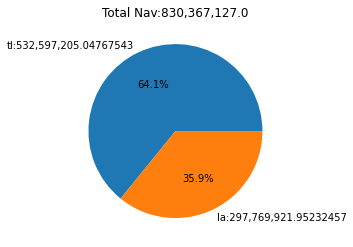

In [71]:
nav_l_2 = [user_df_2[user_name].iloc[-1] for user_name in user_name_l_2]  # type: ignore
label_l_2 = [f"{user_name}:{nav:,}" for user_name, nav in zip(user_name_l_2, nav_l_2)]
draw_utils.plot_nav_pie(nav_l_2, label_l=label_l_2)

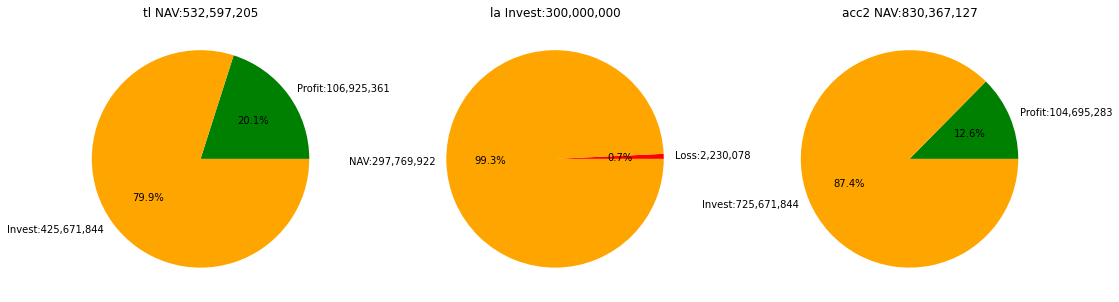

In [72]:
profit_invest_list_2: list[tuple[str, float, float]] = []
for name in user_name_l_2 + [acc_name_2]:
    nav = user_df_2[name].iloc[-1]
    invest = -user_df_2[f"{name}_cf"].sum()
    profit = nav - invest
    profit_invest_list_2.append((name, profit, invest))
draw_utils.plot_profit_invest_pies(profit_invest_list_2)

In [73]:
user_df_2 = process_utils.add_diff_percent(
    user_df_2,
    all_acc_name_l=[acc_name_2],
    index_name_combined_l=[compare_index_2],
)


In [74]:
# Filter 10 latest days
recent_user_df_2 = process_utils.filter_latest_x_rows(user_df_2, row_num=10)


In [75]:
recent_user_df_2

,vni,vni_diff,acc2,acc2_diff,tl_cf,la_cf,acc2_cf,day_start,tl_day_start,tl_share,tl_diff,tl,la_day_start,la_share,la_diff,la,acc2_diff_p,acc2_aux_diff_p,vni_diff_p,vni_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,
2022-04-07,1502.35,-20.55,533923966,-4537506.0,0.0,0.0,0.0,538461472.0,5.384615e+08,1.0000,-4.537506e+06,5.339240e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00,-0.008427,0.991573,-0.013494,0.986506
2022-04-08,1482.00,-20.35,536358112,2434146.0,0.0,0.0,0.0,533923966.0,5.339240e+08,1.0000,2.434146e+06,5.363581e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.004559,1.004559,-0.013545,0.986455
2022-04-12,1455.25,-26.75,534260028,-2098084.0,0.0,0.0,0.0,536358112.0,5.363581e+08,1.0000,-2.098084e+06,5.342600e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00,-0.003912,0.996088,-0.018050,0.981950
2022-04-13,1477.20,21.95,537017705,2757677.0,0.0,0.0,0.0,534260028.0,5.342600e+08,1.0000,2.757677e+06,5.370177e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.005162,1.005162,0.015083,1.015083
2022-04-14,1472.12,-5.08,537477167,459462.0,0.0,0.0,0.0,537017705.0,5.370177e+08,1.0000,4.594620e+05,5.374772e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000856,1.000856,-0.003439,0.996561
2022-04-15,1458.56,-13.56,536585967,-891200.0,0.0,0.0,0.0,537477167.0,5.374772e+08,1.0000,-8.912000e+05,5.365860e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00,-0.001658,0.998342,-0.009211,0.990789
2022-04-18,1432.60,-25.96,835621795,-964172.0,0.0,-300000000.0,-300000000.0,836585967.0,5.365860e+08,0.6414,-6.184196e+05,5.359675e+08,3.000000e+08,0.3586,-3.457524e+05,2.996542e+08,-0.001797,0.998203,-0.017798,0.982202
2022-04-19,1406.45,-26.15,827075354,-8546441.0,0.0,0.0,0.0,835621795.0,5.359675e+08,0.6414,-5.481684e+06,5.304859e+08,2.996542e+08,0.3586,-3.064757e+06,2.965895e+08,-0.010228,0.989772,-0.018254,0.981746
2022-04-20,1384.72,-21.73,828288112,1212758.0,0.0,0.0,0.0,827075354.0,5.304859e+08,0.6414,7.778626e+05,5.312637e+08,2.965895e+08,0.3586,4.348954e+05,2.970244e+08,0.001466,1.001466,-0.015450,0.984550


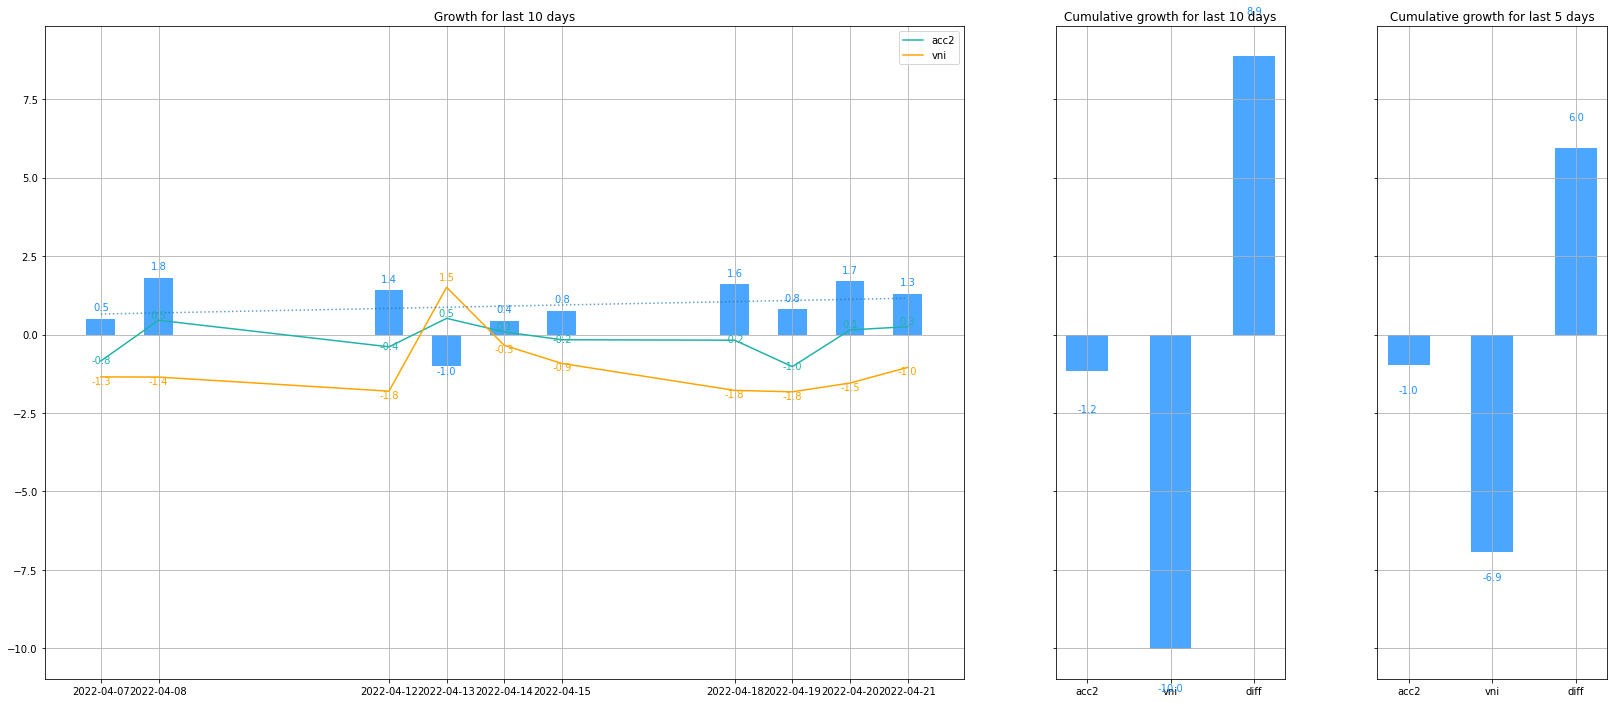

In [76]:
draw_utils.plot_recent_growth(
    recent_user_df_2,
    main_acc_name=acc_name_2,
    main_index_name=compare_index_2,
    secondary_acc_name_l=[],
    secondary_index_name_l=[],
)


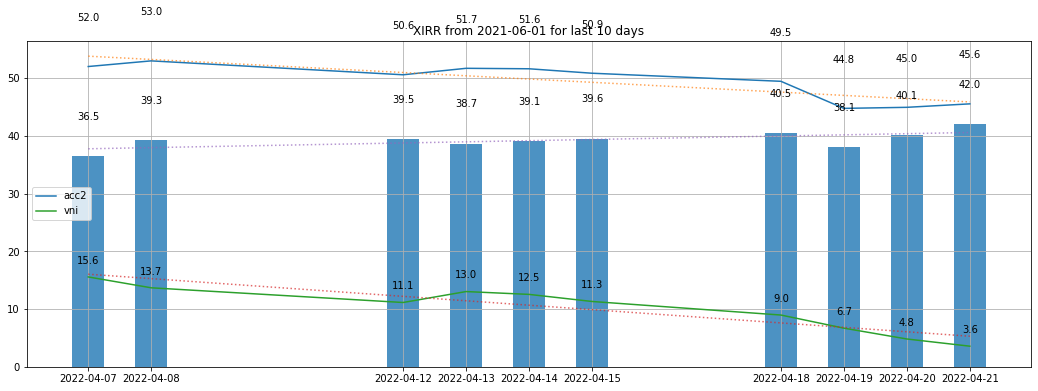

In [77]:
draw_utils.plot_recent_xirr(
    log_df=user_df_2,
    cf_df=cf_df,
    recent_dates_index=recent_user_df_2.index,
    anchor_date="2021-06-01",
    main_acc_name=acc_name_2,
    main_index_name=compare_index_2,
    secondary_acc_name_l=[],
    secondary_index_name_l=[],
)


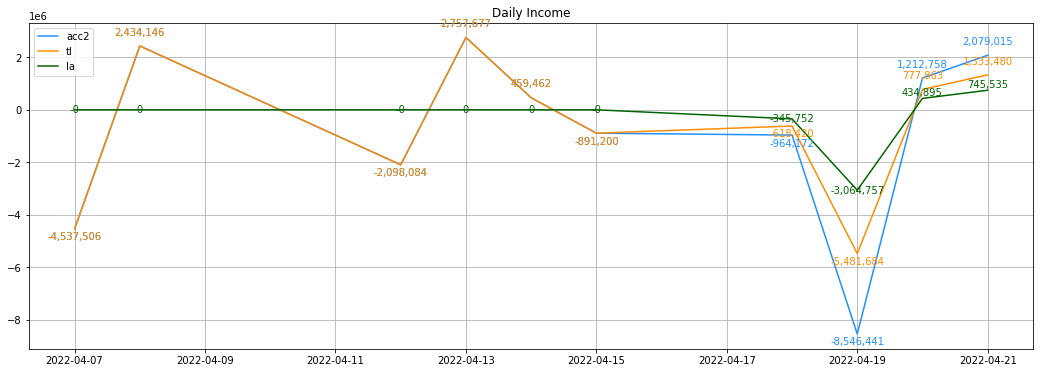

In [78]:
draw_utils.plot_recent_income(
    recent_daily_df=recent_user_df_2,
    name_l=[acc_name_2] + user_name_l_2,
    color_l=const.COLOR_LIST[: len(const.ALL_ACC_NAME_L)],
)